In [1]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [2]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

from ding0.tools import results # to load pickl file


# create new network
nd = NetworkDing0(name='network')


# set ID of MV grid district
mv_grid_districts = [40] # fn 40, 912

In [3]:
# TODO set in config file
ding0_default=False

engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()
create_lvgd_geo_method='convex_hull' # off, convex_hull

In [4]:
%%time

# STEP 1
nd.import_mv_grid_districts(session, mv_grid_districts_no=mv_grid_districts,
                            ding0_default=ding0_default, need_parameterization=True,
                            create_lvgd_geo_method=create_lvgd_geo_method)

Finding connected graph, iteration 1 of max. 4.
Simplified graph: 94 to 22 nodes, 170 to 26 edges
Simplified graph: 716 to 479 nodes, 1484 to 1010 edges
at least one node trespasses dist to substation.                                cluster again with n_clusters+=1
after increment; n_cluster 5
all clusters are in range
=====> MV Grid Districts imported


CPU times: total: 4.36 s
Wall time: 6.28 s


In [5]:
import osmnx as ox
import networkx as nx

In [6]:
from shapely.geometry import LineString

from ding0.core.network import BranchDing0
from ding0.core.network.cable_distributors import LVCableDistributorDing0
from ding0.core.network.loads import LVLoadDing0
from ding0.tools import config as cfg_ding0

from config.config_lv_grids_osm import get_config_osm, get_load_profile_categories
from ding0.grid.lv_grid.parameterization import get_peak_load_for_residential

import logging
logger = logging.getLogger('ding0')

def get_routed_graph(
        graph, station_node, building_nodes, generator_nodes=None):
    '''
    routing via shortest path from station to loads and gens
    input graph representing all streets in lvgd and 
        node of station in graph, all nodes of buildings.
        generator_nodes is none by default due to they are connected 
        in a ding0 default way at a later point corresponding to load
    remove edges which are not mandatory and return routed graph
    '''
    routed_graph = graph.copy()

    edges_to_keep = []
    for n in building_nodes:
        route = nx.shortest_path(graph, n, station_node, weight='length')
        for i, r in enumerate(route[:-1]):
            edges_to_keep.append((r, route[i+1]))
    edges_to_keep = list(set(edges_to_keep))
    edges_to_del = []
    for edge in list(graph.edges()):
        if edge not in edges_to_keep:
            if station_node not in edge:
                edges_to_del.append(edge)
    routed_graph.remove_edges_from(edges_to_del)
    logging.info('Routing shortest path for each node to station. '
                 f'{len(edges_to_del)} edges removed in graph to obtain '
                 'shortest path tree.')
    # due to edges are removed, nodes which are not connected anymore needs to be removed also
    # e.g. nodes which representing intersections on ways but not mandatory for shortest tree
    # graph to route loads to station need to be removed to dont add as ding0CableDist
    for loose_components in list(nx.weakly_connected_components(routed_graph)):
        if len(loose_components) == 1:  # there is only one not conencted node
            for node in loose_components:
                routed_graph.remove_node(node)

    return routed_graph


def get_cable_type_by_load(lvgd, capacity, cable_lf, cos_phi_load, v_nom):
    """ get cable type for given capacity as param """
    I_max_load = capacity / (3 ** 0.5 * v_nom) / cos_phi_load

    # determine suitable cable for this current
    suitable_cables_stub = lvgd.lv_grid.network.static_data['LV_cables'][
        (lvgd.lv_grid.network.static_data['LV_cables'][
            'I_max_th'] * cable_lf) > I_max_load]
    if len(suitable_cables_stub):
        cable_type_stub = suitable_cables_stub.loc[suitable_cables_stub['I_max_th'].idxmin(), :]
    else:  # TODO: what to do if no cable is suitable for I_max_load, e.g. many loads connected to feeder?
        cable_type_stub = lvgd.lv_grid.network.static_data['LV_cables'].iloc[0]  # take strongest cable if no one suits

    return cable_type_stub


def get_number_of_cables(capacity, cos_phi_load, v_nom):
    """ get number of cables for given capacity as param """
    I_max_load = capacity / (3 ** 0.5 * v_nom) / cos_phi_load

    max_possible_i_load = 245
    n_cables = 1
    while I_max_load > max_possible_i_load:
        n_cables +=1
        I_max_load /= n_cables
    return n_cables

In [7]:
# find lvgd (la_id: 4488)
lvgd = nd._mv_grid_districts[0]._lv_load_areas[0]._lv_grid_districts[0]  # max 4

In [8]:
cable_lf = cfg_ding0.get('assumptions',
                         'load_factor_lv_cable_lc_normal')
cos_phi_load = cfg_ding0.get('assumptions',
                             'cos_phi_load')
v_nom = cfg_ding0.get('assumptions', 'lv_nominal_voltage') / 1e3  # v_nom in kV

# get diversity factor for non residential
diversity_factor = get_config_osm('diversity_factor_not_residential')
load_profile_categories = get_load_profile_categories()

# separate loads w. capacity: loads < 100 kW connected to grid
lv_loads_grid = lvgd.buildings.loc[
    lvgd.buildings.capacity < get_config_osm('lv_threshold_capacity')]

# full graph for routing 100 - 200 kW to station
full_graph = lvgd.graph_district  # .to_undirected()

# get graph for loads < 100 kW
shortest_tree_district_graph = get_routed_graph(
    full_graph,  # graph in district
    lvgd.lv_grid._station.osm_id_node,  # osmid of node representating station
    lv_loads_grid.nn.tolist())             # list of nodes connected to staion

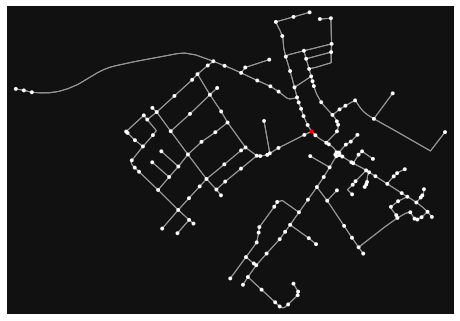

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [9]:
# show full lvgd graph
station_id = [lvgd.lv_grid._station.osm_id_node]
nc = ['r' if n in station_id else 'w' for n in full_graph]
ox.plot_graph(full_graph, node_color=nc)

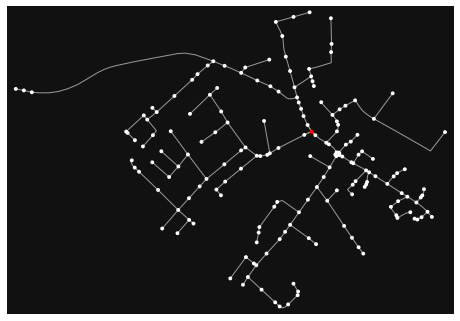

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [10]:
# show shortest path tree graph
# find substations id in street graph
station_id = [lvgd.lv_grid._station.osm_id_node]
nc = ['r' if n in station_id else 'w' for n in shortest_tree_district_graph]
ox.plot_graph(shortest_tree_district_graph, node_color=nc)

In [11]:
import numpy as np

def get_n_feeder_mandatory(capacity): 
    I_max_allowed = 245 ##TODO: get value via config from standard cable type
    I_max_load_at_feeder = capacity / (3 ** 0.5 * v_nom) / cos_phi_load
    return np.ceil(I_max_load_at_feeder / I_max_allowed)

In [35]:
from ding0.grid.lv_grid.routing import identify_street_loads

def allocate_street_load_nodes(lv_loads_grid, shortest_tree_district_graph, station_id):
    
    # in order to do a size constrainted tree partioning
    # allocate capacity to street nodes (as integer)
    street_loads, household_loads = identify_street_loads(lv_loads_grid, shortest_tree_district_graph, get_number_households=True)
    street_loads_map = street_loads.to_dict()['capacity']
    household_loads_map = household_loads.to_dict()['number_households']

    for node in shortest_tree_district_graph.nodes:

        if node in street_loads_map.keys():
            shortest_tree_district_graph.nodes[node]['load'] = int(np.ceil(street_loads_map[node] * 1e3)) # as int * 1000
        else:
            shortest_tree_district_graph.nodes[node]['load'] = 0
        if node in household_loads_map:
            shortest_tree_district_graph.nodes[node]['n_households'] = household_loads_map[node]
        else:
            shortest_tree_district_graph.nodes[node]['n_households'] = 0

    # make sure substation's capacity is always zero
    shortest_tree_district_graph.nodes[station_id]['load'] = 0 
    
    return shortest_tree_district_graph, street_loads, household_loads

In [43]:
%%time

import nxmetis
from ding0.grid.mv_grid.tools import get_shortest_path_shp_multi_target

feeder_graph_list = []

# G. Karypis, V. Kumar: A fast and high quality multilevel scheme for partitioning irregular graphs
# https://www.cs.utexas.edu/~pingali/CS395T/2009fa/papers/metis.pdf

# pre-process graph
# allocate loads to street nodes
shortest_tree_district_graph, street_loads, household_loads = allocate_street_load_nodes(lv_loads_grid, shortest_tree_district_graph, station_id[0])

CPU times: total: 0 ns
Wall time: 12 ms


In [125]:
%%time

# split the graph into subtrees based on station's incident edges
# if number of edges larger 1 
# prepare shortest path tree graph
g = shortest_tree_district_graph.copy()
station_attr = g.nodes[station_id[0]]

# find subtrees in shortest path tree graph using substation's inicident edges
#TODO: Check if len(G) is bigger 1 / G.has_edges: lvgd graph with one node -> remove station leads to empty graph
g.remove_node(station_id[0])

nodelists = list(nx.weakly_connected_components(g))

feederID = 0

# create subtrees from tree graph based on number of with station incident edges
for nodelist in nodelists:
    
    subtree_graph = shortest_tree_district_graph.subgraph(list(nodelist) + station_id).to_undirected()
    
    cum_subtree_load = sum([subtree_graph.nodes[node]['load'] for node in subtree_graph.nodes]) / 1e3
    
    n_feeder = get_n_feeder_mandatory(cum_subtree_load)
    
    print(f"load {cum_subtree_load} needs n_feeder {n_feeder}")
        
    if n_feeder > 1:

        G = nx.Graph(subtree_graph.copy())

        # transform edge length to int
        for edge in G.edges:
            G.edges[edge]['length'] = int(np.ceil(G.edges[edge]['length']))

        (cut, parts) = nxmetis.partition(G, int(n_feeder), 
                                         node_weight='load', edge_weight='length', 
                                         options=nxmetis.MetisOptions(contig=True))
        
        for cluster in parts:
            
            feederID += 1
            
            # get feeder graphs separately
            feeder_graph = subtree_graph.subgraph(cluster).copy()
            
            cum_feeder_graph_load = sum([feeder_graph.nodes[node]['load'] for node in feeder_graph.nodes]) / 1e3
            
            print(f"feeder id {feederID} has a load of {cum_feeder_graph_load}")
            
            suitable_cables_stub = lvgd.lv_grid.network.static_data['LV_cables'][(lvgd.lv_grid.network.static_data['LV_cables']['I_max_th'] * cable_lf) > cum_feeder_graph_load]
            if len(suitable_cables_stub):
                cable_type_stub = suitable_cables_stub.loc[suitable_cables_stub['I_max_th'].idxmin(), :]
            else:  # TODO: what to do if no cable is suitable for I_max_load, e.g. many loads connected to feeder?
                cable_type_stub = lvgd.lv_grid.network.static_data['LV_cables'].iloc[0]  # take strongest cable if no one suits
            
            for node in cluster:
                feeder_graph.nodes[node]['feederID'] = feederID
                
            for edge in feeder_graph.edges:
                feeder_graph.edges[edge]['feederID'] = feederID
                feeder_graph.edges[edge]['cum_load'] = cum_feeder_graph_load
                feeder_graph.edges[edge]['cable_type_stub'] = cable_type_stub

            if not station_id[0] in feeder_graph.nodes:

                line_shp, line_length, line_path = get_shortest_path_shp_multi_target(subtree_graph, station_id[0], cluster)
                feeder_graph.add_edge(line_path[0], station_id[0], 0, geometry=line_shp, length=line_length, feederID=feederID, cable_type_stub=cable_type_stub)
                feeder_graph.add_node(station_id[0], **station_attr)
                
            feeder_graph_list.append(feeder_graph)
                
    else:
        
        feederID += 1
        
        feeder_graph = subtree_graph.copy()
        
        print(f"feeder id {feederID} has a load of {cum_subtree_load}")
        
        suitable_cables_stub = lvgd.lv_grid.network.static_data['LV_cables'][(lvgd.lv_grid.network.static_data['LV_cables']['I_max_th'] * cable_lf) > cum_subtree_load]
        if len(suitable_cables_stub):
            cable_type_stub = suitable_cables_stub.loc[suitable_cables_stub['I_max_th'].idxmin(), :]
        else:  # TODO: what to do if no cable is suitable for I_max_load, e.g. many loads connected to feeder?
            cable_type_stub = lvgd.lv_grid.network.static_data['LV_cables'].iloc[0]  # take strongest cable if no one suits
            
        for node in feeder_graph.nodes:
            feeder_graph.nodes[node]['feederID'] = feederID

        for edge in feeder_graph.edges:
            feeder_graph.edges[edge]['feederID'] = feederID
            feeder_graph.edges[edge]['cum_load'] = cum_subtree_load
            feeder_graph.edges[edge]['cable_type_stub'] = cable_type_stub
            
        feeder_graph_list.append(feeder_graph)


load 352.178 needs n_feeder 3.0
feeder id 1 has a load of 115.398
feeder id 2 has a load of 163.731
feeder id 3 has a load of 73.049
load 178.178 needs n_feeder 2.0
feeder id 4 has a load of 75.429
feeder id 5 has a load of 102.749
load 156.463 needs n_feeder 1.0
feeder id 6 has a load of 156.463
CPU times: total: 172 ms
Wall time: 168 ms


In [126]:
lvgd.lv_grid.network.static_data['LV_cables'][(lvgd.lv_grid.network.static_data['LV_cables']['I_max_th'] * cable_lf) > 115.398]

,U_n,I_max_th,R_per_km,L_per_km
name,,,,
NAYY 4x1x300,400,419,0.100,0.279
NAYY 4x1x240,400,364,0.125,0.254
NAYY 4x1x185,400,313,0.164,0.256
NAYY 4x1x150,400,275,0.206,0.256
NAYY 4x1x120,400,245,0.253,0.256
NAYY 4x1x95,400,215,0.320,0.261
NAYY 4x1x50,400,144,0.449,0.270
NAYY 4x1x35,400,123,0.868,0.271


In [127]:
suitable_cables_stub = lvgd.lv_grid.network.static_data['LV_cables'][(lvgd.lv_grid.network.static_data['LV_cables']['I_max_th'] * cable_lf) > 115.398]
if len(suitable_cables_stub):
    pass
    cable_type_stub = suitable_cables_stub.loc[suitable_cables_stub['I_max_th'].idxmin(), :]
else:  # TODO: what to do if no cable is suitable for I_max_load, e.g. many loads connected to feeder?
    cable_type_stub = lvgd.lv_grid.network.static_data['LV_cables'].iloc[0]  # take strongest cable if no one suits
suitable_cables_stub

,U_n,I_max_th,R_per_km,L_per_km
name,,,,
NAYY 4x1x300,400,419,0.100,0.279
NAYY 4x1x240,400,364,0.125,0.254
NAYY 4x1x185,400,313,0.164,0.256
NAYY 4x1x150,400,275,0.206,0.256
NAYY 4x1x120,400,245,0.253,0.256
NAYY 4x1x95,400,215,0.320,0.261
NAYY 4x1x50,400,144,0.449,0.270
NAYY 4x1x35,400,123,0.868,0.271


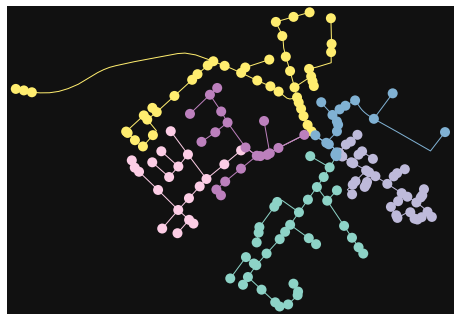

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [128]:
G = nx.compose_all(feeder_graph_list)
#G.nodes[station_id[0]]['feederID'] = 0

ec = ox.plot.get_edge_colors_by_attr(G, attr='feederID', cmap="Set3")
nc = ox.plot.get_node_colors_by_attr(G, attr='feederID', cmap="Set3")
ox.plot_graph(G, node_color=nc, edge_color=ec, node_size=100)

In [131]:
shown_id_stub = []
for e in G.edges:
    if G.edges[e]['feederID'] not in shown_id_stub:
        shown_id_stub.append(G.edges[e]['feederID'])
        print(G.edges[e]['feederID'], G.edges[e]['cable_type_stub'].name)


1 NAYY 4x1x35
2 NAYY 4x1x95
3 NAYY 4x1x35
4 NAYY 4x1x35
5 NAYY 4x1x35
6 NAYY 4x1x95


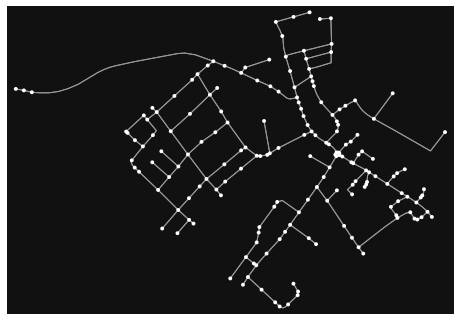

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [135]:
ox.plot_graph(lvgd.graph_district)